## Everything associated with the recommendation algorithm

In [57]:
import pprint
import pickle
import psycopg2
import numpy as np
import pandas as pd
import datetime
from dateutil.parser import parse
from datetime import timedelta
import random
import copy
import matplotlib.pyplot as plt
from pylab import *
import gensim
from gensim.models import CoherenceModel, HdpModel, LdaModel, LdaMulticore
import re, nltk, spacy
from collections import Counter

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

In [1]:
# Pre-process docs & make them tokenised. 
# Pre-processed data to be used for aspect identification from the pre-built LDA models.
def pre_process_text(texts):
    texts = [re.sub(r'\S*@\S*\s?', '', text) for text in texts]
    texts = [re.sub(r'\s+', ' ', text) for text in texts]
    texts = [re.sub(r"\'", "", text) for text in texts]
    
    def sent_to_words(sentences):
        for sentence in sentences:
            yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
    texts = list(sent_to_words(texts))
    
    ## NLTK Stop words
    from nltk.corpus import stopwords
    stop_words = stopwords.words('english')
    stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'say']) 
    def remove_stopwords(sentences):
        return [[word for word in sentence if word not in stop_words] for sentence in sentences]
    texts = remove_stopwords(texts)
    
    ## Bigram stuff
    bigram = gensim.models.Phrases(texts, min_count=5, threshold=100)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    texts = [bigram_mod[text] for text in texts]
    
    ## Lemmatization
    def lemmatization(sentences, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
        """https://spacy.io/api/annotation"""
        docs = [nlp(" ".join(sentence)) for sentence in sentences] 
        return [[token.lemma_ for token in doc if token.pos_ in allowed_postags] for doc in docs]
    
    nlp = spacy.load('en', disable=['parser', 'ner'])
    texts = lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    
    return texts

In [59]:
# Assign LDA aspects for all articles ...
def getAspects(texts, lda_model):

    # pre-process texts & convert text to tokens
    pptxts = pre_process_text(texts)
    pptxts = [lda_model.id2word.doc2bow(pptxt) if pptxt else [] for pptxt in pptxts]
    
    # Then find LDA aspects, pick scores > 0.3 if exists, else max
    probs = [lda_model[pptxt] for pptxt in pptxts]
    aspects = [[p[0] for p in prob if p[1]>=0.3] for prob in probs]
    for i in range(len(aspects)):
        if aspects[i] == []:
            aspects[i] = [max(probs[i], key=lambda y:y[1])[0]]
            
    return aspects

In [2]:
# Get local records that I have in this folder, load LDA, and find mappings
# Note the data structure used: Records are a 2d numpy arrays, where each element is a list of 4 things - 
# <index, list of aspect ids, text, date>
# The records can be extended to have more than just these 4 fields in case extra metadata is needed. 
# The code still works fine.
def getLocalRecs(article_path, lda_model_path):
    # Load Data
    file = open(article_path, 'rb')
    data = pickle.load(file)

    # Load LDA Model
    lda_model = LdaModel.load(lda_model_path)

    recs = np.empty(shape = (0, 4))
    idx = 0
    for key, val in data.items():
        for texts in val:
            recs = vstack( (recs, np.array([idx, [], texts, parse(key).date()])) )
            idx += 1

    # Get all aspects and stitch
    aspects_col = getAspects(recs[:,2], lda_model)
    recs[:, 1] = aspects_col

    no_of_aspects = lda_model.num_topics
    return recs, no_of_aspects

In [61]:
# Get mapped records from PostgreSQL
def getRecords(event_id):
    # Get data from postgreSQL tables
    conn = psycopg2.connect("dbname=debanjan_media_database user=debanjan_final password=Deb@12345 host=10.237.26.159 port=5432")
    cur = conn.cursor()

    query = "select * from art_info_final where event_id="+str(event_id)
    cur.execute(query)
    records = cur.fetchall()
    
    #Id->1
    #Aspects->2
    #Url->4
    #Date->13
    records = np.array(records)
    records = records[:,[1,2,4,13]]
    for record in records:
        record[1] = [int(x) for x in record[1]]
    
    records = records[records[:,3].argsort()]
    no_of_aspects = 21
    return records, no_of_aspects

In [63]:
def getShortProductionFunc(end_date, period, records, no_of_aspects):
    ret = [0]*no_of_aspects
    
    period = timedelta(days=period)
    startTime = end_date-period
    
    produced = records[ (records[:,3] >= startTime) & (records[:,3] <= end_date) ]
    total_produced = len(produced)
    
    if total_produced == 0:
        return np.array(ret)
    
    allAspectsProduced = np.sum(produced[:,1])
    ret = [allAspectsProduced.count(i)/total_produced for i, x in enumerate(ret)]
    return np.array(ret)

In [64]:
def getDesiredDist(no_of_aspects):
    # Equal distribution case
    ret = np.array([1/no_of_aspects]*no_of_aspects)
    return ret

In [113]:
#achieved distribution is (number of articles with aspect i)/(number of total articles) - multilabel
def getAchievedDist(feed_list, feed_dates=None, time=None):
    ret = [0]*no_of_aspects
    
    #Filter articles based on date -- optional
    if(feed_dates is None):
        feed_list = np.vstack(feed_list)
    else:
        oldest_date = feed_dates[-1] - timedelta(days=time)
        list_of_indices = [idx for idx, val in enumerate(feed_dates) if val > oldest_date]
        feed_list = [feed_list[idx] for idx in list_of_indices]
    
    #Count each aspect
    total_list = np.vstack(feed_list)
    allAspectsProduced = np.sum(total_list[:,1])
    
    if allAspectsProduced == 0:
        return np.array(ret)
    
    #Sum total
    total_articles = len(total_list)
    
    ret = [allAspectsProduced.count(i)/total_articles for i, x in enumerate(ret)]
    return np.array(ret)

In [114]:
#achieved distribution is (number of articles with aspect i)/(sum of number of aspects in each article) - multilabel
def getAchievedRelDist(feed_list, feed_dates=None, time=None):
    ret = [0]*no_of_aspects
    
    #if len(feed_list) == 0 or len(feed_list[0]) == 0:
    #    return np.array(ret)
    
    #Filter articles based on feed-produce date -- optional
    if(feed_dates is None):
        feed_list = np.vstack(feed_list)
    else:
        oldest_date = feed_dates[-1] - timedelta(days=time)
        list_of_indices = [idx for idx, val in enumerate(feed_dates) if val > oldest_date]
        feed_list = [feed_list[idx] for idx in list_of_indices]
    
    #Count each aspect
    total_list = np.vstack(feed_list)
    allAspectsProduced = np.sum(total_list[:,1])
    
    # check if total list was empty, instead of returning a list ^ would then return 0.
    if allAspectsProduced == 0:
        return np.array(ret)
    
    #Sum total
    total_all_aspects = len(allAspectsProduced)
    
    ret = [allAspectsProduced.count(i)/total_all_aspects for i, x in enumerate(ret)]
    return np.array(ret)

In [115]:
def fair_scores(Dj, Aj):
    Wj = Dj - Aj
    if not Wj.any():
        return Dj
    return (Wj - np.min(Wj))/(np.max(Wj) - np.min(Wj))

In [174]:
# Routine for getting a feed based on random sampling or sampling acc to the production distribution
def runRandomFeed(records, alpha, beta, gamma, no_of_aspects):
    ### Parameters
    T0 = datetime.date(2011, 7, 1) 
    # This is the default start date. Since our collection is from 1/1/2011 and we build LDA on 6 months,
    # we start simulating system from 1/7/2011
    Tf = records[-1][3]
    feed_publication_freq = 1 #how frequently to publish a feed (in days)?
    feed_size = 4 #Just the initial feed-size. We use TCP based estimation subsequently.
    ###
    
    feed_list, feed_dates, feed_HHIs, feed_GINIs, feed_AGEs = [], [], [], [], []
    next_date = T0
    while next_date <= Tf:
        
        # Get articles before end date from last 15 days and sort reverse
        start_date = next_date - timedelta(days=15)
        published = records[ (records[:,3] >= start_date) & (records[:,3] <= next_date) ]
        published = published[published[:,3].argsort()[::-1]]
        
        # Feed Size => TCP retransmission based estimation technique.
        RTTm = len( published[published[:,3] == next_date] )
        if next_date == T0:
            RTTs = RTTm
            RTTd = RTTm/2
        else:
            RTTs = (1 - alpha)*RTTs + (alpha)*RTTm
            RTTd = (1 - beta)*RTTd + (beta)*(RTTm-RTTs)
        feed_size = int(RTTs + gamma*RTTd)
        feed_size = max(feed_size, 1)
        
        #Get news feed randomly without replacement
        indexes = np.random.choice(len(published), size=min(feed_size, len(published)), replace=False)
        feed = published[indexes]
        feed_list.append(feed)
        feed_dates.append(next_date)
        
        # Process last 15 days for short term diversity, last 90 days for long term fairness.
        # Change and divide 15 and 90 below by `feed_publication_freq` if it is not 1.
        feed_HHIs.append(getHHI(feed_list[-15:]))
        feed_GINIs.append(getGINI(feed_list[-90:], no_of_aspects))
        
        # Get average age of an article in the news feed
        if len(feed) == 0:
            feed_AGEs.append(0)
        else:
            ages = (next_date - feed[:,3])
            ages = ages / timedelta(days=1)
            feed_AGEs.append(np.mean(ages))

        #increment next date
        next_date = next_date + timedelta(feed_publication_freq)
        
    return feed_list, feed_dates, feed_HHIs, feed_GINIs, feed_AGEs

In [175]:
# Routine for getting a feed based on picking greedily the recent articles
def runLatestFeed(records, no_of_aspects):
    ### Parameters
    T0 = datetime.date(2011, 7, 1) 
    # This is the default start date. Since our collection is from 1/1/2011 and we build LDA on 6 months,
    # we start simulating system from 1/7/2011    
    Tf = records[-1][3]
    feed_publication_freq = 1 #how frequently to publish a feed (in days)?
    feed_size = 4 #Just the initial feed-size. We use TCP based estimation subsequently.    
    ###
    
    feed_list, feed_dates, feed_HHIs, feed_GINIs, feed_AGEs = [], [], [], [], []
    next_date = T0
    while next_date <= Tf:
        
        #Get articles before end date and sort reverse
        start_date = next_date - timedelta(days=15)
        published = records[ (records[:,3] >= start_date) & (records[:,3] <= next_date) ]
        published = published[published[:,3].argsort()[::-1]]
        
        # Feed Size => TCP retransmission based estimation technique.
        RTTm = len( published[published[:,3] == next_date] )
        if next_date == T0:
            RTTs = RTTm
            RTTd = RTTm/2
        else:
            RTTs = (1 - 1/8)*RTTs + (1/8)*RTTm
            RTTd = (1 - 1/4)*RTTd + (1/4)*(RTTm-RTTs)
        feed_size = int(RTTs + 2*RTTd)
        feed_size = max(feed_size, 1)
        
        #Get news feed picking latest articles
        feed = published[0:feed_size]
        feed_list.append(feed)
        feed_dates.append(next_date)
        
        # Process last 15 days for short term diversity, last 90 days for long term fairness.
        # Change and divide 15 and 90 below by `feed_publication_freq` if it is not 1.
        feed_HHIs.append(getHHI(feed_list[-15:]))
        feed_GINIs.append(getGINI(feed_list[-90:], no_of_aspects))
        
        # Get average age of an article
        if len(feed) == 0:
            feed_AGEs.append(0)
        else:
            ages = (next_date - feed[:,3])
            ages = ages / timedelta(days=1)
            feed_AGEs.append(np.mean(ages))
        
        #increment next date
        next_date = next_date + timedelta(feed_publication_freq)
        
    return feed_list, feed_dates, feed_HHIs, feed_GINIs, feed_AGEs

In [177]:
# Routine for getting a feed based on our recommendation algorithm
def runBasicHeur(records, no_of_aspects, min_thr, div_coeff):
    ################ Parameters
    short_production_period = 15
    T0 = datetime.date(2011, 7, 1)
    Tf = records[-1][3]
    feed_publication_freq = 1
    #feed_size = 4
    ################
    
    feed_list, feed_dates, feed_HHIs, feed_GINIs, feed_AGEs = [], [], [], [], []
    rolling_window = 90
    
    next_date = T0
    while next_date <= Tf:
        if next_date == T0:
            Aj = np.array([1/no_of_aspects]*no_of_aspects)
        else:
            Aj = getAchievedRelDist(feed_list, feed_dates = feed_dates, time = rolling_window)
            
        SPj = getShortProductionFunc(next_date, short_production_period, records, no_of_aspects)
        Dj = (min_thr)*getDesiredDist(no_of_aspects) + (1-min_thr)*SPj
        
        #Calculate aspect scores
        aspect_scores = fair_scores(Dj , Aj)
        
        # Feed Size => TCP retransmission based estimation technique.
        RTTm = len( records[records[:,3] == next_date] )
        if next_date == T0:
            RTTs = RTTm
            RTTd = RTTm/2
        else:
            RTTs = (1 - 1/8)*RTTs + (1/8)*RTTm
            RTTd = (1 - 1/4)*RTTd + (1/4)*(RTTm-RTTs)
        feed_size = int(RTTs + 2*RTTd)
        feed_size = max(feed_size, 1)
        
        #from IPython import embed; embed()
        
        #Get news feed
        feed = getArticleList(aspect_scores, records, feed_size, next_date, no_of_aspects, div_coeff, feed_list[-14:])
        feed_list.append(feed)
        feed_dates.append(next_date)
        
        # Get Diversiy and Fairness scores
        feed_HHIs.append(getHHI(feed_list[-15:]))
        feed_GINIs.append(getGINI(feed_list[-90:], no_of_aspects))
        
        # Get average age of an article
        if len(feed) == 0:
            feed_AGEs.append(0)
        else:
            ages = (next_date - feed[:,3])
            ages = ages / timedelta(days=1)
            feed_AGEs.append(np.mean(ages))
        
        #increment next date
        next_date = next_date + timedelta(feed_publication_freq)
        
    return feed_list, feed_dates, feed_HHIs, feed_GINIs, feed_AGEs

In [4]:
# Sub-routine to fill a particular day's news feed for our recommendation algorithm.
# Here we use least over-exposed article approach. 
# - Basically calculate which aspect violates the upper bound contraint the least. 
# - Pick the most recent unpicked article, repeat until feed is filled.

def getArticleList(aspect_scores, all_records, feed_size, end_date, no_of_aspects, div_coeff, past_feed_list):
    ret_feed = np.empty( (0, all_records.shape[1]) )
        
    #1. Get aspects & aspect scores, normalise them
    aspects = np.array(range(no_of_aspects))
    
    if np.sum(aspect_scores) == 0:
        aspect_scores = np.array([1/no_of_aspects]*no_of_aspects)
    norm_aspect_scores = aspect_scores/np.sum(aspect_scores)
    
    #2. Set up local exposure constraint for diversity - Elisa Celis
    # Include a div_coeff ~~> represents diversity coefficient
    a1l = norm_aspect_scores
    
    #b1l => diversity scores. 
    # Distribute equally only amongst the ones where atleast an article occurs.
    start_date = end_date - timedelta(days=15)
    last15 = all_records[ (all_records[:,3] >= start_date) & (all_records[:,3] <= end_date) ]
    asps = np.sum(last15[:,1])
    b1l = getDivScores(no_of_aspects, asps)
    
    u1l = (1-div_coeff)*a1l + (div_coeff)*b1l
    #print(u1l)
    
    #3. Filter articles from last 15 days (rev. chrono.) - we consider only last 15 day articles
    published_new = getMoreArticles(u1l, 1.5, feed_size, start_date, end_date, all_records, no_of_aspects)

    #4. Initialise aspect exposures observed over last 14 days and filled counter
    asp_exposure = np.array([0]*no_of_aspects)
    if len(past_feed_list) != 0:
        past_feed_list = np.vstack(past_feed_list)
        for article in past_feed_list:
            asp_exposure[article[1]] += 1 
    filled = len(past_feed_list)
    
    def pickLeastViolatingAspect(aspects, u1l, asp_exposure):
        np.random.shuffle(aspects)
        violation = asp_exposure - (filled+1)*u1l
        #print(violation)
        for a in violation.argsort():
            if a in aspects:
                return a
        
    #5. Start filling slots
    # Try that aspect which violates constraint the least
    # If can't find an article for it - update asp_exposure, u1l, aspects; continue;
    for slot in range(feed_size):
        
        # Exhausted constraints or not;
        found = False
        while not found:
            
            # If all violate constraint - let the feed be this much only
            if len(aspects) == 0:
                break
            each_aspect = pickLeastViolatingAspect(aspects, u1l, asp_exposure)
            
            for index, article in enumerate(published_new):
                if each_aspect in article[1]:
                    ret_feed = np.vstack([ret_feed, article])
                    published_new = np.delete(published_new, (index), axis=0)
                    index -= 1
                    filled += 1

                    # Update all aspect's exposures
                    asp_exposure[np.intersect1d(article[1], aspects)] += 1

                    found = True
                    break
            
            if not found:
                # print("Mayhem, couldn\'t find - ", each_aspect)
                # If that aspect does not exist in any recent articles - 
                # then delete that aspect - doesn't violate & not found
                aspects = np.delete(aspects, np.where(aspects == each_aspect))
                
                # Redistribute the rest feed among other aspects
                filled -= asp_exposure[each_aspect]
                u1l = u1l/u1l[aspects].sum()
    
    #print("Feed filled :=> ",len(ret_feed),"/",feed_size)
    return ret_feed

In [ ]:
# Sub routine to get more articles when lower bound constraint is not satisified in the last 15 days 
# for certain aspects. To use or to not use Lj is a design question
def getMoreArticles(uj, k, feed_size, start_date, end_date, all_records, no_of_aspects):
    
    ## Comment the below 3 lines in case you want to include lower bound constraints as well.
    last15 = all_records[ (all_records[:,3] >= start_date) & (all_records[:,3] <= end_date) ]
    last15 = last15[last15[:,3].argsort()[::-1]]
    return last15

## Uncomment this below, and comment the above 3 lines, in case lower bound is also taken in consideration.
## Beware it can siginificantly increase the avg. feed agem which was a reason why we discarded it.
#     req_count = uj/(k*1.0)
#     req_count = req_count*feed_size
    
#     # Take articles in past 6 months, but not in last 15 days
#     start_date2 = end_date - timedelta(days=180)
#     last3m = all_records[ (all_records[:,3] >= start_date2) & (all_records[:,3] <= start_date) ]
#     last3m = last3m[last3m[:,3].argsort()[::-1]]
    
#     last15 = all_records[ (all_records[:,3] >= start_date) & (all_records[:,3] <= end_date) ]
#     last15 = last15[last15[:,3].argsort()[::-1]]
    
#     asps = np.sum(last15[:,1])
#     cur_count = [0]*no_of_aspects
#     if(asps != 0):
#         cur_count = np.array([asps.count(i) for i, x in enumerate(cur_count)])
#     else:
#         cur_count = np.array(cur_count)
    
#     for i in range(no_of_aspects):
#         if cur_count[i] < req_count[i]:
#             for ind, art in enumerate(last3m):
#                 if i in art[1]:
#                     last15 = np.vstack([last15, art])
#                     cur_count[art[1]] += 1
#                     np.delete(last3m, (ind), axis=0)
#                     ind -= 1
#     return last15

In [ ]:
# Split the fraction only for those aspects that have occured atleast once in the last 15 days.
def getDivScores(no_of_aspects, asps):
    occured=0
    b1l = np.array([0.0]*no_of_aspects)
    if asps == 0.0:
        return b1l
    for i in range(no_of_aspects):
        if i in asps:
            occured += 1
            b1l[i] = 1.0
    b1l = b1l/occured
    return b1l

In [186]:
## Calculate HHI over a set of feeds
def getHHI(feeds):
    #feeds = np.array()
    feed = np.vstack(feeds)
    if len(feed) == 0:
        return 0 
    
    dist = getAchievedRelDist([feed])
    
    score = np.sum(dist**2)
    #print(dist, score)
    return score

In [179]:
## Calculate GINI over a set of feeds
def getGINI(feeds, no_of_aspects):
    feed = np.vstack(feeds)
    
    if len(feed) == 0:
        return 0
    
    # Count each aspect
    x = np.sum(feed[:,1])
    freq = Counter(x)
    vals = [freq[val] for val in range(no_of_aspects)]
    
    # Taken from Stack Overflow
    vals = np.asarray(vals)
    sorted_vals = np.sort(vals)
    n = len(vals)
    cumvals = np.cumsum(sorted_vals, dtype=float)
    # The above formula, with all weights equal to 1 simplifies to:
    gini_val = (n + 1 - 2 * np.sum(cumvals) / cumvals[-1]) / n
    
    return gini_val

## Running the system

### Get Data

In [ ]:
event_name, event_id = 'aadhar', 0 # 'demonetisation', 'gst', 'farmers'

In [3]:
## Get Data

## Uncomment one of these if you need to find LDA Mappings again,
## Note however that to create LDA models in the first place we use a different script.

## If you have LDA Map ready, and want to connect to MongoDB
#records, no_of_aspects = getRecords(0)

## If you have LDA Map ready, and have articles locally stored
# records, no_of_aspects = getLocalRecs(event_name+'Model/sorted_date_to_text_'+event_name+'.pkl', \
#                                      event_name+'Model/'+event_name+'.model')  

#print(len(records), ", ", no_of_aspects, records[-1][3])

In [129]:
# Cache!
## with open('records-'+event_name+'.pkl', 'wb') as f:
##     pickle.dump((records, no_of_aspects), f)

# If you have already found LDA mappings once, and have it all locally stored.
with open('records-' +event_name+ '.pkl', 'rb') as f:
    records, no_of_aspects = pickle.load(f)

### Run all simulations for 3 policies: Random, Latest, and Heuristic

In [194]:
#Get all news feeds
feed_list_rnd, feed_dates_rnd, feed_HHI_rnd, feed_GINI_rnd, feed_AGE_rnd = runRandomFeed(records, 1/8, 1/4, 2, no_of_aspects)
feed_list_fr, feed_dates_fr, feed_HHI_fr, feed_GINI_fr, feed_AGE_fr = runLatestFeed(records, no_of_aspects)
feed_list_hr, feed_dates_hr, feed_HHI_hr, feed_GINI_hr, feed_AGE_hr = runBasicHeur(records, no_of_aspects, 0.5, 0.8)

### Store feeds for later analysis

In [83]:
#1-> without those 2 extra improvements for constraint relaxations as in mail (1, 0.5)
#2-> with them (0.5, 0.7)
#3-> with additionally 15 day diverse thing (0.5, 0.8) and without Lj
with open("GAComparisonData/"+event_name+"_rnd3.pkl", "wb") as fp:
    pickle.dump((feed_list_rnd, feed_dates_rnd, feed_HHI_rnd, feed_GINI_rnd, feed_AGE_rnd), fp)
with open("GAComparisonData/"+event_name+"_fr3.pkl", "wb") as fp:
    pickle.dump((feed_list_fr, feed_dates_fr, feed_HHI_fr, feed_GINI_fr, feed_AGE_fr), fp)
with open("GAComparisonData/"+event_name+"_hr3.pkl", "wb") as fp:
    pickle.dump((feed_list_hr, feed_dates_hr, feed_HHI_hr, feed_GINI_hr, feed_AGE_hr), fp)

### Draw GINI, HHI & Feed Age

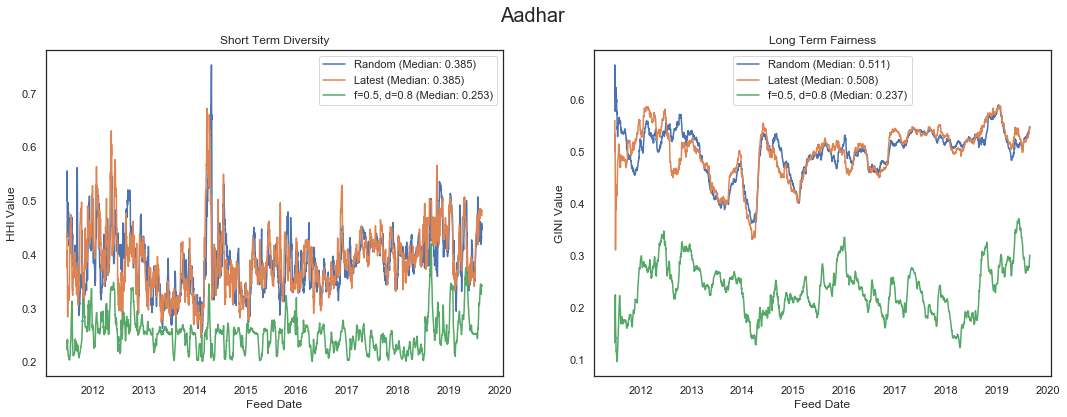

In [131]:
figs, axes = plt.subplots(1, 2, figsize=(18, 6))
figs.suptitle(event_name.title(), size=20 )

# Plot HHIs
axes[0].set_xlabel("Feed Date")
axes[0].set_ylabel("HHI Value")
axes[0].set_title("Short Term Diversity")
axes[0].plot(feed_dates_rnd, feed_HHI_rnd, label='Random (Median: %.3f)'%np.median(feed_HHI_rnd) )
axes[0].plot(feed_dates_fr, feed_HHI_fr, label='Latest (Median: %.3f)'%np.median(feed_HHI_fr) )
axes[0].plot(feed_dates_hr, feed_HHI_hr, label='f=0.5, d=0.8 (Median: %.3f)'%np.median(feed_HHI_hr) )
axes[0].legend()

# Plot GINIs
axes[1].set_xlabel("Feed Date")
axes[1].set_ylabel("GINI Value")
axes[1].set_title("Long Term Fairness")
axes[1].plot(feed_dates_rnd, feed_GINI_rnd, label='Random (Median: %.3f)'%np.median(feed_GINI_rnd) )
axes[1].plot(feed_dates_fr, feed_GINI_fr, label='Latest (Median: %.3f)'%np.median(feed_GINI_fr) )
axes[1].plot(feed_dates_hr, feed_GINI_hr, label='f=0.5, d=0.8 (Median: %.3f)'%np.median(feed_GINI_hr) )
axes[1].legend()

figs.savefig('Baseline-'+event_name+'1.png', bbox_inches='tight')

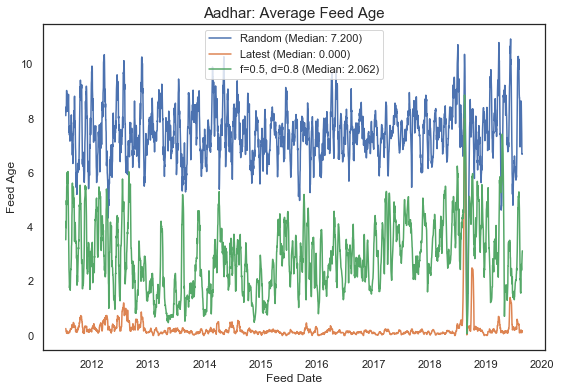

In [137]:
#Age of articles
figs, axes = plt.subplots(1, 1, figsize=(9, 6))

df_rnd = pd.DataFrame(feed_AGE_rnd, index=feed_dates_rnd)
df_rnd = df_rnd.rolling(window=15).mean()
df_fr = pd.DataFrame(feed_AGE_fr, index=feed_dates_fr)
df_fr = df_fr.rolling(window=15).mean()
df_hr = pd.DataFrame(feed_AGE_hr, index=feed_dates_hr)
df_hr = df_hr.rolling(window=15).mean()

axes.set_xlabel("Feed Date")
axes.set_ylabel("Feed Age")
axes.set_title(event_name.title()+": Average Feed Age",size=15 )
axes.plot(df_rnd.index, df_rnd, label='Random (Median: %.3f)'%np.median(feed_AGE_rnd) )
axes.plot(df_fr.index, df_fr, label='Latest (Median: %.3f)'%np.median(feed_AGE_fr) )
axes.plot(df_hr.index, df_hr, label='f=0.5, d=0.8 (Median: %.3f)'%np.median(feed_AGE_hr) )
axes.legend()

### 2-sample tests

In [139]:
from scipy import stats

In [141]:
print(stats.ks_2samp(feed_GINI_rnd, feed_GINI_hr))
print(stats.ks_2samp(feed_GINI_fr, feed_GINI_hr))

print(stats.ks_2samp(feed_HHI_rnd, feed_HHI_hr))
print(stats.ks_2samp(feed_HHI_fr, feed_HHI_hr))

Ks_2sampResult(statistic=0.9952972791400739, pvalue=0.0)
Ks_2sampResult(statistic=0.9808532079274437, pvalue=0.0)
Ks_2sampResult(statistic=0.8891501511588847, pvalue=0.0)
Ks_2sampResult(statistic=0.8814242526032919, pvalue=0.0)


## Parameter Callibration to determine the best choice

In [99]:
fc = np.arange(0 , 1.1 ,0.1)
dc = np.arange(0 , 1.1 ,0.1)

In [100]:
median_HHIs = np.zeros((fc.shape[0],fc.shape[0]))
median_GINIs = np.zeros((fc.shape[0],fc.shape[0]))
median_AGEs = np.zeros((fc.shape[0],fc.shape[0]))
median_SIZEs = np.zeros((fc.shape[0],fc.shape[0]))

In [101]:
for i in range(len(fc)):
    print(i)
    for j in range(len(dc)):
        feed_listij, feed_datesij, feed_HHIij, feed_GINIij, feed_AGEij = runBasicHeur(records, no_of_aspects, fc[i], dc[j])
        median_HHIs[i][j] = np.median(feed_HHIij) 
        median_GINIs[i][j] = np.median(feed_GINIij)
        median_AGEs[i][j] = np.median(feed_AGEij)
        median_SIZEs[i][j] = getMeanFeedSize(feed_listij)

/Users/chakshu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:131: RuntimeWarning: divide by zero encountered in true_divide
/Users/chakshu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in true_divide


In [102]:
with open("results_"+event_name+"3.pkl", "wb") as fp:
    pickle.dump((median_HHIs, median_GINIs, median_AGEs, median_SIZEs), fp)

In [53]:
with open("results_"+event_name+"3.pkl", "rb") as fp:
    median_HHIs, median_GINIs, median_AGEs, median_SIZEs = pickle.load(fp)

### Short Term Diversity

Text(30.5, 0.5, 'Fairness Coefficient')

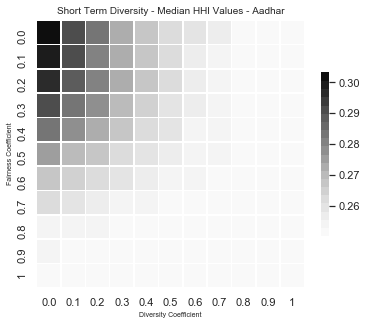

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
cmap = sns.color_palette("Greys", 20)
f, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(median_HHIs, cmap=cmap, vmin=median_HHIs.min(), vmax=median_HHIs.max(),
                 square=True, linewidths=.5, cbar_kws={"shrink": .5},
                 xticklabels=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], 
                 yticklabels=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.set_title('Short Term Diversity - Median HHI Values - '+event_name.title(), fontsize = 10)
plt.xlabel('Diversity Coefficient', fontsize = 7) # x-axis label with fontsize 15
plt.ylabel('Fairness Coefficient', fontsize = 7)

### Long Term Fairness

Text(30.5, 0.5, 'Fairness Coefficient')

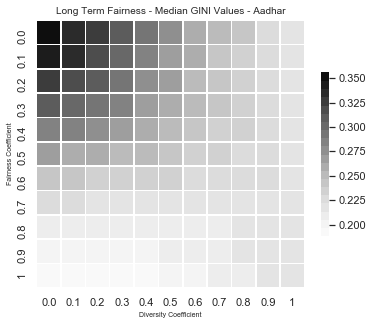

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
cmap = sns.color_palette("Greys", 20)
f, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(median_GINIs, cmap=cmap, vmin=median_GINIs.min(), vmax=median_GINIs.max(),
                 square=True, linewidths=.5, cbar_kws={"shrink": .5},
                 xticklabels=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], 
                 yticklabels=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.set_title('Long Term Fairness - Median GINI Values - '+event_name.title(), fontsize = 10)
plt.xlabel('Diversity Coefficient', fontsize = 7) # x-axis label with fontsize 15
plt.ylabel('Fairness Coefficient', fontsize = 7)


### Feed Age

Text(30.5, 0.5, 'Fairness Coefficient')

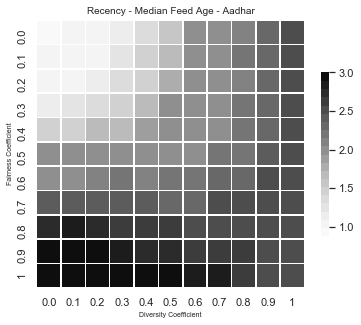

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
cmap = sns.color_palette("Greys", 20)
f, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(median_AGEs, cmap=cmap, vmin=median_AGEs.min(), vmax=median_AGEs.max(),
                 square=True, linewidths=.5, cbar_kws={"shrink": .5},
                 xticklabels=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], 
                 yticklabels=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.set_title('Recency - Median Feed Age - '+event_name.title(), fontsize = 10)
plt.xlabel('Diversity Coefficient', fontsize = 7) # x-axis label with fontsize 15
plt.ylabel('Fairness Coefficient', fontsize = 7)

### Combined: For best parameter

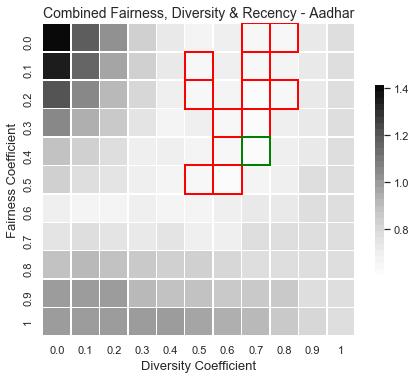

In [160]:
median_GINIs_norm = (median_GINIs - np.min(median_GINIs))/(np.max(median_GINIs) - np.min(median_GINIs))
median_HHIs_norm = (median_HHIs - np.min(median_HHIs))/(np.max(median_HHIs) - np.min(median_HHIs))
median_AGEs_norm = (median_AGEs - np.min(median_AGEs))/(np.max(median_AGEs) - np.min(median_AGEs))
comb = (median_GINIs_norm**2 + median_HHIs_norm**2 + median_AGEs_norm**2)**(0.5)

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
sns.set(style="white")
cmap = sns.color_palette("Greys", 30)
f, ax = plt.subplots(figsize=(7, 7))
ax = sns.heatmap(comb, cmap=cmap, vmin=comb.min(), vmax=comb.max(),
                 square=True, linewidths=.5, cbar_kws={"shrink": .5},
                 xticklabels=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], 
                 yticklabels=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.set_title('Combined Fairness, Diversity & Recency - '+event_name.title(), fontsize = 14)
plt.xlabel('Diversity Coefficient', fontsize = 13) # x-axis label with fontsize 15
plt.ylabel('Fairness Coefficient', fontsize = 13)
#ax.tick_params(axis='both', which='major', labelsize=12)

min_cells = np.argwhere(comb <= np.min(comb)*1.10)
for cell in min_cells:
    ax.add_patch(Rectangle((cell[1],cell[0]), 1, 1, fill=False, edgecolor='red', lw=2))

min_cell = np.unravel_index(comb.argmin(), comb.shape)
ax.add_patch(Rectangle((min_cell[1],min_cell[0]), 1, 1, fill=False, edgecolor='green', lw=2))
f.savefig('graphs/'+event_name+'_grid.png', bbox_inches='tight')

### Average Feed Size - For sanity check, are we really filling feeds

Text(30.5, 0.5, 'Fairness Coefficient')

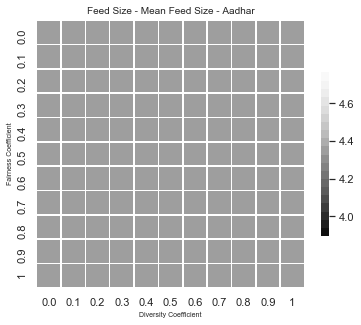

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
cmap = sns.color_palette("Greys_r", 20)
f, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(median_SIZEs, cmap=cmap, vmin=median_SIZEs.min(), vmax=median_SIZEs.max(),
                 square=True, linewidths=.5, cbar_kws={"shrink": .5},
                 xticklabels=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], 
                 yticklabels=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.set_title('Feed Size - Mean Feed Size - '+event_name.title(), fontsize = 10)
plt.xlabel('Diversity Coefficient', fontsize = 7) # x-axis label with fontsize 15
plt.ylabel('Fairness Coefficient', fontsize = 7)

## Callibrating feed-size calculation parameters.

4.192139737991266


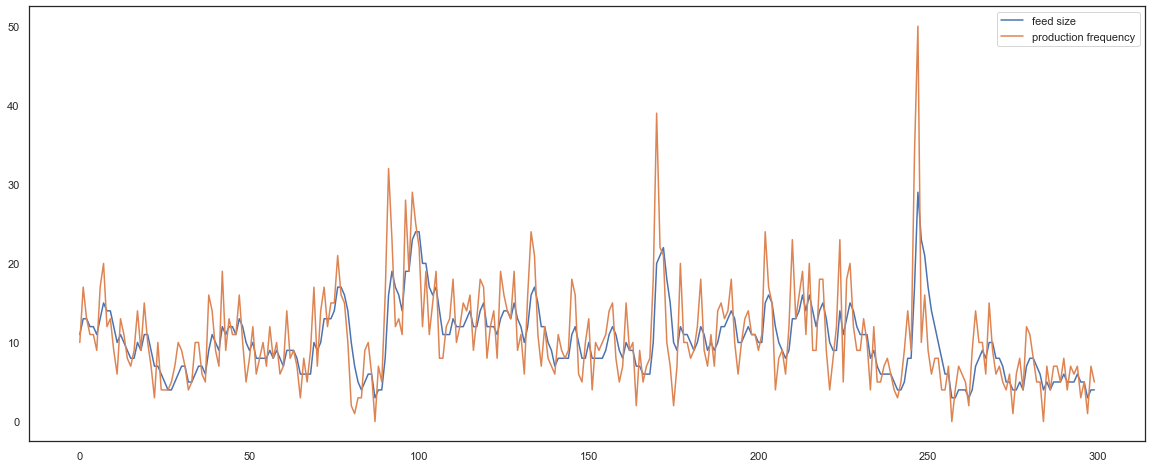

In [212]:
tcpi=0
for alpha in range(1, 17):
    for beta in range(1, 17):
        for gamma in range(1, 3):
            feed_list_rnd, feed_dates_rnd, feed_HHI_rnd, feed_GINI_rnd, feed_AGE_rnd = runRandomFeed(records, 1/alpha, 1/beta, gamma, no_of_aspects)
            figs, axes = plt.subplots(1, 1, figsize=(20, 8))
            tcpi+=1
            av=0
            cn=0
            arr=[]
            cm=[]
            for day_feed in feed_list_rnd:
                arr.append(len(day_feed))
                cn+=1
                av+=len(day_feed)

            for fdate in feed_dates_rnd:
                cm.append(len(records[records[:,3] == fdate]))

            print(av/cn)
            plt.plot(arr[2000:2300], label='feed size')
            plt.plot(cm[2000:2300], label='production frequency')
            plt.legend()
            plt.savefig('tcp'+str(tcpi)+'.png')

## Misc: TimeSeries Analysis

### Adapt the code below as it suits

4.961826614341777


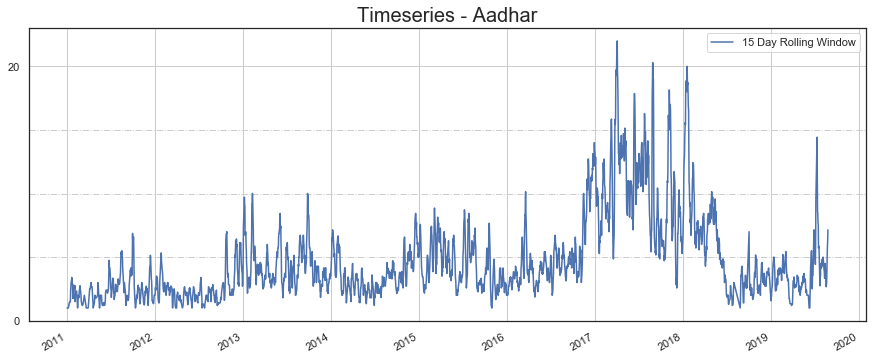

In [37]:
dateMap = {}

for article in records:
    ptime = pd.to_datetime( article[3] )

    if ptime in dateMap:
        dateMap[ptime] += 1
    else:
        dateMap[ptime] = 1
dateMap = pd.DataFrame([dateMap]).transpose()
rolMean15 = dateMap.rolling(window='7d').mean()
tot_mean = str(dateMap.mean(axis = 0)[0])
print(tot_mean)
figs, axes = plt.subplots(1, 1, figsize=(15, 6))
rolMean15.plot(ax=axes, grid = True)
axes.set_title('Timeseries - ' + event_name.title(), fontsize = 20)
axes.yaxis.set_major_locator(MultipleLocator(20))
axes.yaxis.set_minor_locator(MultipleLocator(5))
axes.yaxis.grid(which="minor", linestyle='-.')
axes.legend(['15 Day Rolling Window'])

### Aspect-Wise Timeseries Analysis

In [38]:
dateMap = {}
mean_each_aspect = []
for aspect in range(no_of_aspects):
    dateMap[aspect] = {}
    tm = pd.to_datetime(datetime.date(2011,1,1))
    
    while tm <= pd.to_datetime(datetime.date(2019,8,24)):
        dateMap[aspect][tm] = 0
        tm += pd.DateOffset(1)
    
    for article in records:
        ptime = pd.to_datetime( article[3] )
        if aspect in article[1]:
            if ptime in dateMap[aspect]:
                dateMap[aspect][ptime] += 1
                
    dateMap[aspect] = pd.DataFrame([dateMap[aspect]]).transpose()
    tot_mean = str(dateMap[aspect].mean(axis = 0)[0])
    mean_each_aspect.append(tot_mean)
    print(aspect , " - " , tot_mean)

0  -  0.2963901203293224
1  -  0.6440785307156428
2  -  2.791956934768841
3  -  0.04274857504749842
4  -  2.5094996833438885


([<matplotlib.axis.XTick at 0x1a24f64b70>,
 <a list of 5 Text xticklabel objects>)

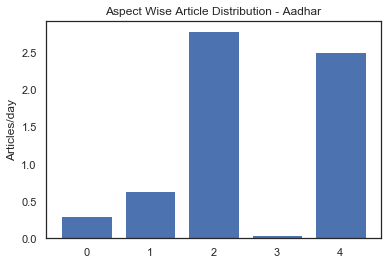

In [39]:
mean_each_aspect = [float(m) for m in mean_each_aspect]
plt.bar(list(range(no_of_aspects)), mean_each_aspect)
plt.ylabel('Articles/day')
plt.title('Aspect Wise Article Distribution - '+event_name.title())
plt.xticks(list(range(no_of_aspects)))

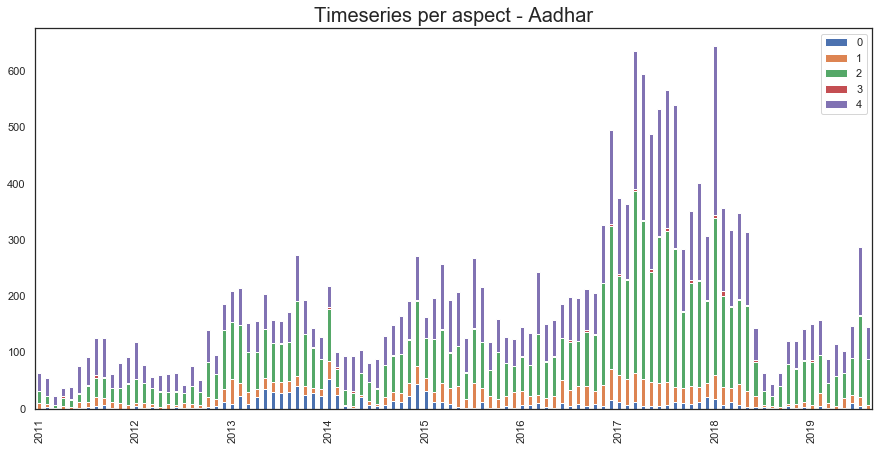

In [40]:
timeFrame = dateMap[0]
for aspect in range(no_of_aspects):
    if aspect is not 0:
        timeFrame = pd.concat([timeFrame, dateMap[aspect]], axis=1, sort=False)
timeFrame.columns = list(range(no_of_aspects))

tf = timeFrame.groupby(pd.Grouper(freq='M')).sum()

fig, y = plt.subplots(figsize=(15,7))
tf.plot(ax=y, kind='bar', stacked=True)

y.set_title('Timeseries per aspect - '+event_name.title(), fontsize = 20)

labels = ['']*len(tf.index)
labels[::12] = [item.strftime('%Y') for item in tf.index[::12]]
y.xaxis.set_major_formatter(matplotlib.ticker.FixedFormatter(labels))

figs.savefig("timeframe-tmp.png", bbox_inches='tight')